## Food item modeling
The Branded food items are not labeled or categorized but have an ingredients list provided by the manufacturer.  The ingredients in a food label are listed in decreasing order by weight.  
* For a simple categorization method, observe how item similarities change as the number of elements (ingredients) are successively increased
E.g. use the first 5 items to calculate cosine similarity for each food item, then cluster.  

In [255]:
from sklearn.decomposition import NMF, LatentDirichletAllocation
import re
import string
import pickle

In [1]:
# Retrieve pickled standard reference food items (175228 total)
with open("../../../food_data/br_food_items_list","r") as f: 
    food_items = pickle.load(f)

In [112]:
# Food item IDs, names, and their ingredients
food_items[:5]

[(u'45001524',
  u'MOCHI ICE CREAM BONBONS, UPC: 019022128593',
  u'ICE CREAM INGREDIENTS: MILK, CREAM, SUGAR, STRAWBERRIES (STRAWBERRIES, SUGAR), CORN SYRUP SOLIDS, SKIM MILK, WHEY, NATURAL FLAVOR, GUAR GUM, MONO & DIGLYCERIDES, BEET JUICE AND BEET POWDER (FOR COLOR), CELLULOSE GUM, LOCUST BEAN GUM, CARRAGEENAN. COATING INGREDIENTS: SUGAR, WATER, RICE FLOUR, TREHALOSE, EGG WHITES, BEET JUICE AND BEET POWDER (FOR COLOR), DUSTED WITH CORN & POTATO STARCH'),
 (u'45001528',
  u'CHIPOTLE BARBECUE SAUCE, UPC: 5051379043735',
  u'WATER, SUGAR, TOMATO PASTE, MOLASSES, DISTILLED VINEGAR, CONTAINS 2% OR LESS OF: CORN STARCH, SALT, DRIED CHIPOTLE PEPPER, NATURAL SMOKE FLAVOR, MUSTARD FLOUR, DRIED GARLIC, DRIED ONION, SPICES.'),
 (u'45001529',
  u'BARBECUE SAUCE, UPC: 5051379009434',
  u'SUGAR, WATER, DISTILLED VINEGAR, TOMATO PASTE, MOLASSES MODIFIED CORN STARCH, SALT, PINEAPPLE JUICE CONCENTRATE, CONTAINS 1% OR LESS OF: JALAPENO PEPPERS, SPICE, CARAMEL COLOR, NATURAL FLAVOR, XANTHAN GUM, GARLIC

In [219]:
# isolate the ingredients list from food_items
ingredients_list = [a[2] for a in food_items]

## Parsing individual ingredients from `ingredients_list`

In [344]:
# Obtain the first ingredient of each food item.
# First pass: Split on commas and evaluate
# Without stemming or further processing, this reduces the list to .16 of origina
first_ingredient = [a.split(',')[0] for a in ingredients_list]

print "count of all first terms:", len(first_ingredient)
print "count of unique terms:", len(set(first_ingredient))
print "ratio: {}".format(1.*len(set(first_ingredient))/len(first_ingredient))

count of all first terms: 175228
count of unique terms: 28208
ratio: 0.160978838998


In [348]:
# It is observed that there are many ingredients lists are not separated by commas: 
# periods, hyphens, semicolons, or no punctuation at all (spaces) are used
# There are also ingredients lists split into sub-components, either enclosed 
# in parentheses or following a semicolon.  
# View some samples: 
[a for a in first_ingredient if len(a.split()) > 10][:10]

[u'ORGANIC ENRICHED PETITE PASTA SHELLS [ORGANIC DURUM WHEAT SEMOLINA FLOUR (NIACIN',
 u'MADE WITH ROASTED PEANUTS AND SUGAR. CONTAINS 2% OR LESS OF MOLASSES',
 u'ORGANIC CULTURED PASTEURIZED REDUCED FAT MILK. LIVE ACTIVE CULTURES: L. ACIDOPHILUS',
 u'PASTEURIZED AND CULTURED ORGANIC SOYMILK (FILTERED WATER AND GROUND ORGANIC SOYBEANS)',
 u'CULTURED PASTEURIZED GRADE A LOWFAT MILK AND NONFAT MILK SOLIDS. CONTAINS ACTIVE YOGURT CULTURES.',
 u'TURBINADO SUGAR; WHOLE WHEAT PASTRY FLOUR; COCOA; MILLED FLAX SEED; SALT.',
 u'CANE SUGAR*; **COCOA*; CHOCOLATE*; CINNAMON*; CAYENNE PEPPER*; MILK*(LESS THAN0. 1%). *ORGANIC',
 u'IDAHO POTATOES* WITH EMULSIFIER (MONO & DIGLYCERIDES) AND PRESERVATIVES (SODIUM ACID PYROPHOSPHATE',
 u'RAVIOLI INGREDIENTS: ENRICHED EXTRA FANCY DURUM FLOUR AND SEMOLINA (DURUM WHEAT FLOUR',
 u'CASSIA ACUTIFOLIA DELILE (SENNA LEAF); FOLIUM SENNAE; TINNEVELLY SENNA; CASSIA ANGUSTIFOLIA VAHL.']

In [349]:
# Use regular expressions to split ingredients_list by all relevant separators
pattern = re.compile(r'[.,;]|(- )|\*')
list1 = [re.split(pattern, a.lower()) for a in ingredients_list]

In [350]:
first_list1 = [a[0] for a in list1]

num_words_first = [len(a.split()) for a in first_list1]

counter_first_list1 = collections.Counter(num_words_first)

counter_first_list1

In [253]:
# Observe sample of terms of various lengths
for a in counter_first_list1.keys(): 
    index = [k for k,v in enumerate(num_words_first) if v ==a][0]
    print "\nnumber of words: {}, index: {} \n{}".format(a, index, first_list1[index])


number of words: 0, index: 148 


number of words: 1, index: 1 
water

number of words: 2, index: 3 
tomato puree(water

number of words: 3, index: 9 
organic grain vinegar

number of words: 4, index: 0 
ice cream ingredients: milk

number of words: 5, index: 27 
prepared dark red kidney beans

number of words: 6, index: 106 
parmesan cheese (pasteurized part-skim cow's milk

number of words: 7, index: 157 
enriched macaroni (durum and enriched wheat flour

number of words: 8, index: 334 
blueberries & oats  unbleached wheat flour ( flour

number of words: 9, index: 846 
enriched macaroni product (durum and wheat flour with niacin

number of words: 10, index: 900 
cultured pasteurized grade a lowfat milk and nonfat milk solids

number of words: 11, index: 159 
organic enriched petite pasta shells [organic durum wheat semolina flour (niacin

number of words: 12, index: 1148 
ravioli ingredients: enriched extra fancy durum flour and semolina (durum wheat flour

number of words: 13, inde

In [ ]:
# Assess number of punctuations in each ingredients list.  


# Set cut-off at 17 words  
# Weed out lists with no punctuation 


In [260]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [272]:
import pprint

In [279]:
ingredients_list[0]
collections.Counter(re.findall(r'[!"#$%&\\\\\'()*+,-./:;<=>?@\[\]^_`{|}~\']', ingredients_list[0]))

Counter({u'&': 2, u'(': 3, u')': 3, u',': 20, u'.': 1, u':': 2})

In [310]:
# Get count of all punctuations in ingredients list
all_punctuation_counter = collections.Counter(re.findall(r'[!"#$%&\\\\\'()*+,-./:;<=>?@\[\]^_`{|}~\']', 
                                                         " ".join(ingredients_list)))
all_punctuation_counter.most_common()

[(u',', 1767190),
 (u'(', 237166),
 (u')', 219593),
 (u'.', 149518),
 (u':', 42010),
 (u'[', 36531),
 (u'%', 35382),
 (u']', 33167),
 (u'*', 31914),
 (u'-', 25488),
 (u'&', 17422),
 (u'/', 16643),
 (u'#', 9427),
 (u';', 4690),
 (u"'", 4684),
 (u'{', 3074),
 (u'}', 2786),
 (u'+', 1364),
 (u'"', 419),
 (u'_', 207),
 (u'>', 184),
 (u'!', 169),
 (u'<', 150),
 (u'?', 55),
 (u'=', 20),
 (u'|', 11),
 (u'\\', 7),
 (u'$', 6),
 (u'@', 5),
 (u'`', 2)]

In [282]:
punctuation_counter = []
for a in ingredients_list: 
    punctuation_counter.append(collections.Counter(re.findall(r'[!"#$%&\\\\\'()*+,-./:;<=>?@\[\]^_`{|}~\']', a)).most_common())

In [308]:
split_ingredients_list = [] 
for i,a in enumerate(ingredients_list):
    split_ingredients_list.append([a.split(punctuation_counter[i][0][1])])

TypeError: coercing to Unicode: need string or buffer, int found

In [297]:
collections.Counter([a[0][0] for a in punctuation_counter if len(a)!=0])

Counter({u'!': 16,
         u'"': 22,
         u'#': 33,
         u'%': 1297,
         u'&': 46,
         u"'": 17,
         u'(': 35,
         u')': 1979,
         u'*': 1250,
         u'+': 55,
         u',': 156262,
         u'-': 372,
         u'.': 8999,
         u'/': 91,
         u':': 445,
         u';': 329,
         u'[': 6,
         u']': 1,
         u'|': 1,
         u'}': 1})

In [290]:
collections.Counter([a[0] for a in punctuation_counter])

IndexError: list index out of range

Structure of ingredients list: Some are composed of multiple sentences (i.e. `ingredients_list[0]`)

In [ ]:
# For each ingredients list, count number of each punctuation `{,.:()-}`

#ingredients_list.count()

In [134]:
sep_by_periods = [len(a.split('.')) for a in ingredients_list]

In [135]:
import collections

In [309]:
sep_by_periods_count = collections.Counter(sep_by_periods)
sep_by_periods_count

Counter({1: 50339,
         2: 111371,
         3: 8902,
         4: 2146,
         5: 971,
         6: 579,
         7: 467,
         8: 151,
         9: 83,
         10: 40,
         11: 41,
         12: 64,
         13: 35,
         14: 5,
         15: 14,
         16: 4,
         17: 3,
         18: 1,
         19: 3,
         20: 1,
         21: 1,
         22: 1,
         23: 1,
         26: 1,
         28: 2,
         39: 1,
         71: 1})

In [ ]:
# Words to remove: ['ingredients', 'ingredient']

In [311]:
from sklearn.feature_extraction.text import CountVectorizer
cvectorizer = CountVectorizer(min_df=5, strip_accents="ascii", stop_words='english')

In [312]:
dtm = cvectorizer.fit_transform(ingredients_list)

In [313]:
dtm.shape

(175228, 4994)

In [104]:
cvectorizer.vocabulary_

{u'pgpr': 1290,
 u'mackerel': 1021,
 u'yellow': 1923,
 u'straws': 1676,
 u'asian': 154,
 u'zante': 1935,
 u'consists': 464,
 u'segments': 1536,
 u'swai': 1708,
 u'hormone': 851,
 u'deli': 558,
 u'figs': 654,
 u'baking': 169,
 u'probiotic': 1373,
 u'wholemeal': 1903,
 u'solution': 1607,
 u'superfood': 1701,
 u'capsicum': 327,
 u'uncooked': 1822,
 u'specially': 1633,
 u'bacon': 164,
 u'japanese': 908,
 u'millet': 1096,
 u'cactus': 301,
 u'milled': 1095,
 u'enchiladas': 609,
 u'cooking': 472,
 u'dicoccum': 570,
 u'galangal': 725,
 u'new': 1153,
 u'pancakes': 1226,
 u'herb': 833,
 u'jasmine': 911,
 u'china': 391,
 u'active': 90,
 u'100': 2,
 u'dry': 590,
 u'lychee': 1013,
 u'california': 310,
 u'pack': 1220,
 u'golden': 761,
 u'slices': 1588,
 u'pangasius': 1227,
 u'soybean': 1622,
 u'metabisulfite': 1083,
 u'calm': 313,
 u'type': 1812,
 u'99': 81,
 u'98': 80,
 u'pecan': 1265,
 u'90': 73,
 u'93': 75,
 u'92': 74,
 u'95': 77,
 u'94': 76,
 u'97': 79,
 u'96': 78,
 u'root': 1479,
 u'nitrates': 

In [105]:
import numpy as np

In [106]:
# sums up the term frequencies
dtm.sum(axis=0)

matrix([[  11,   29, 1680, ...,   12,    6,   93]])

Order branded food items according to the amount of common ingredients they have. 

In [110]:
# Show ingredient terms ordered by frequency 

sorted(zip(cvectorizer.get_feature_names(), 
           np.asarray(dtm.sum(axis=0)).ravel()), 
       key=lambda x:x[1], 
       reverse=True)

[(u'flour', 32239),
 (u'water', 27202),
 (u'wheat', 23529),
 (u'milk', 20077),
 (u'sugar', 18620),
 (u'organic', 14541),
 (u'enriched', 12956),
 (u'pasteurized', 9489),
 (u'corn', 8131),
 (u'oil', 5273),
 (u'cultured', 5153),
 (u'chocolate', 4729),
 (u'syrup', 4704),
 (u'filtered', 4595),
 (u'rice', 4458),
 (u'carbonated', 4187),
 (u'tomatoes', 4078),
 (u'ingredients', 3988),
 (u'cream', 3855),
 (u'grain', 3527),
 (u'bleached', 3406),
 (u'beans', 3349),
 (u'potatoes', 3346),
 (u'tomato', 3252),
 (u'chicken', 3226),
 (u'peanuts', 3080),
 (u'cheese', 2936),
 (u'pork', 2901),
 (u'skim', 2886),
 (u'unbleached', 2869),
 (u'juice', 2786),
 (u'nonfat', 2750),
 (u'white', 2729),
 (u'beef', 2586),
 (u'puree', 2501),
 (u'grade', 2435),
 (u'semolina', 2430),
 (u'salt', 2278),
 (u'oats', 2260),
 (u'fat', 2135),
 (u'durum', 2014),
 (u'green', 1939),
 (u'almonds', 1886),
 (u'roasted', 1782),
 (u'coconut', 1748),
 (u'concentrate', 1733),
 (u'brown', 1710),
 (u'100', 1680),
 (u'soybean', 1678),
 (u're

In [53]:
three_ingredients = [' '.join(a.split(',')[:3]) for a in ingredients_list]

In [80]:
import collections

In [88]:
five_ingredients_list = [a.split(',')[:5] for a in ingredients_list]

In [92]:
counter = collections.Counter([a for b in five_ingredients_list for a in b])

In [93]:
counter.most_common(50)

[(u' WATER', 29061),
 (u' SALT', 28847),
 (u' SUGAR', 26786),
 (u' NIACIN', 16437),
 (u'SUGAR', 11072),
 (u' REDUCED IRON', 10487),
 (u'WATER', 10137),
 (u' CITRIC ACID', 9719),
 (u' CORN SYRUP', 9389),
 (u' THIAMINE MONONITRATE', 7739),
 (u' RIBOFLAVIN', 6787),
 (u' HIGH FRUCTOSE CORN SYRUP', 6123),
 (u' COCOA BUTTER', 5177),
 (u' THIAMIN MONONITRATE', 4598),
 (u' MALTED BARLEY FLOUR', 4257),
 (u' VINEGAR', 4062),
 (u' IRON', 3648),
 (u' SEA SALT', 3608),
 (u' DEXTROSE', 3365),
 (u'CARBONATED WATER', 3330),
 (u' CREAM', 3261),
 (u' SALT.', 3171),
 (u' CHEESE CULTURE', 3024),
 (u'FILTERED WATER', 2767),
 (u' NATURAL FLAVOR', 2767),
 (u' SOYBEAN OIL', 2675),
 (u' MALTODEXTRIN', 2558),
 (u' CANE SUGAR', 2542),
 (u'ENRICHED FLOUR (WHEAT FLOUR', 2512),
 (u' DISTILLED VINEGAR', 2460),
 (u'CORN SYRUP', 2399),
 (u' ENZYMES', 2271),
 (u' NATURAL FLAVORS', 2185),
 (u' CHOCOLATE LIQUOR', 2182),
 (u' MILK', 2078),
 (u'POTATOES', 2042),
 (u' GELATIN', 2030),
 (u' MODIFIED CORN STARCH', 1956),
 (u'

In [97]:
dtm.sort_indices

<bound method csr_matrix.sort_indices of <175228x2004 sparse matrix of type '<type 'numpy.int64'>'
	with 465787 stored elements in Compressed Sparse Row format>>

In [75]:
import wordcloud
import matplotlib.pyplot as plt

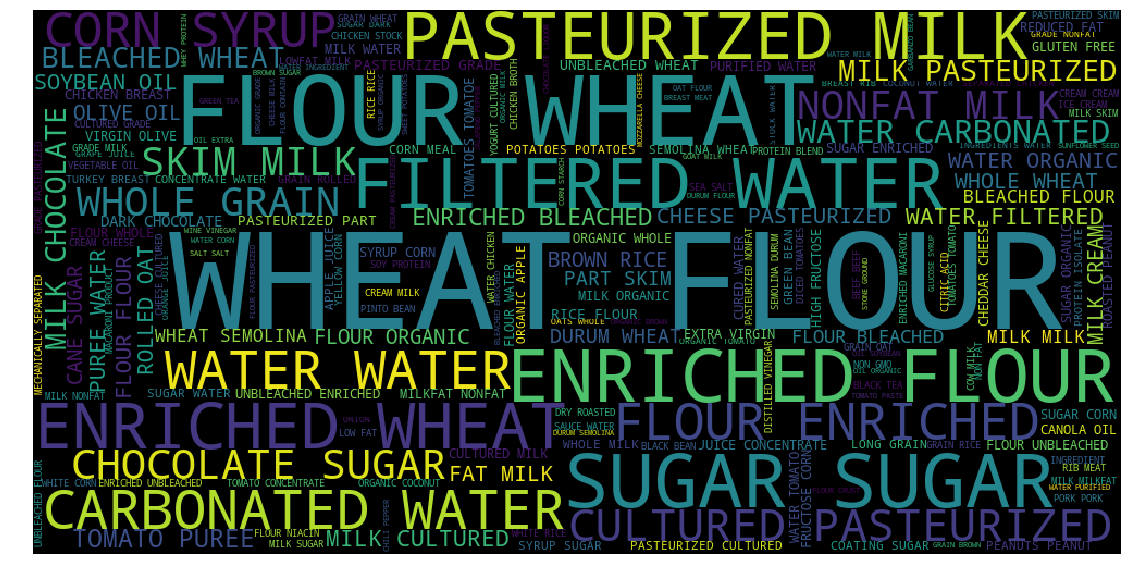

In [76]:
wc = wordcloud.WordCloud(width = 1000, height = 500).generate(' '.join(first_ingredient))
plt.figure(figsize=(20,10))
plt.imshow(wc)
plt.axis("off")
plt.show()

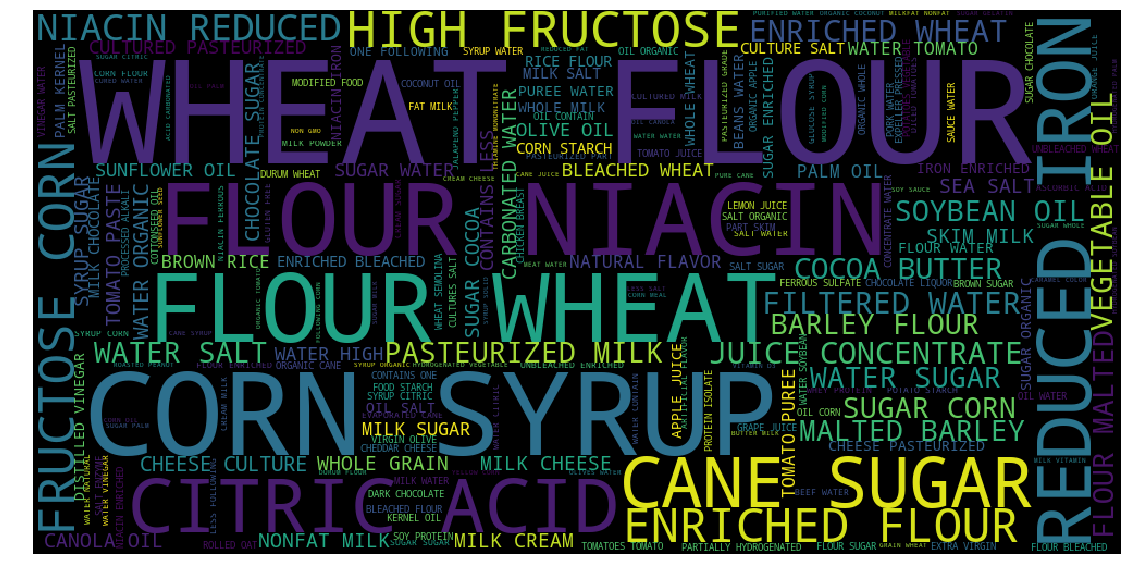

In [77]:
wc = wordcloud.WordCloud(width = 1000, height = 500).generate(' '.join(three_ingredients))
plt.figure(figsize=(20,10))
plt.imshow(wc)
plt.axis("off")
plt.show()

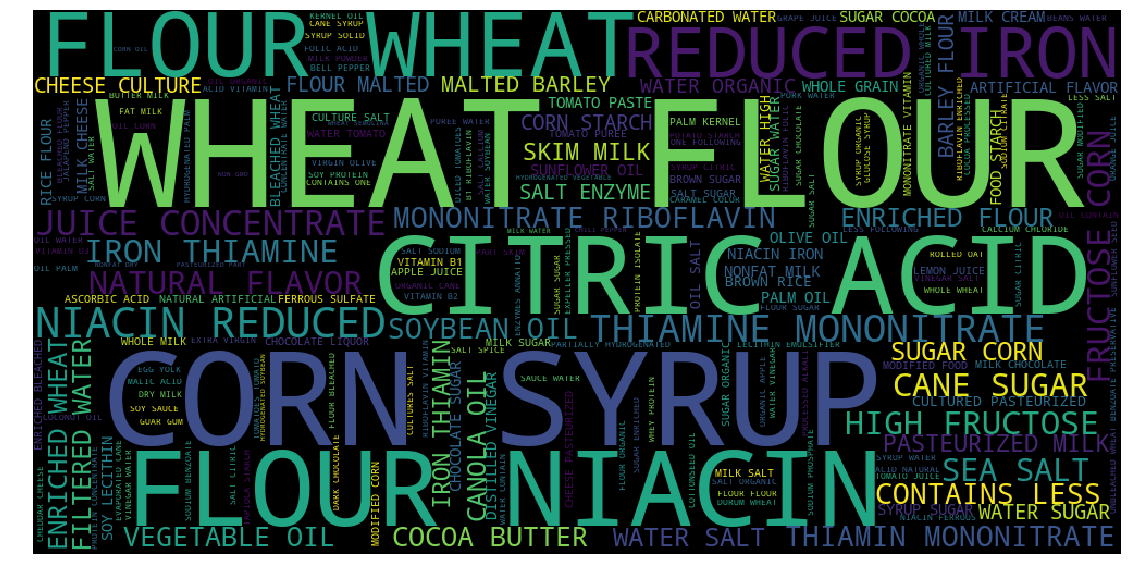

In [78]:
five_ingredients = [' '.join(a.split(',')[:5]) for a in ingredients_list]
wc = wordcloud.WordCloud(width = 1000, height = 500).generate(' '.join(five_ingredients))
plt.figure(figsize=(20,10))
plt.imshow(wc)
plt.axis("off")
plt.show()

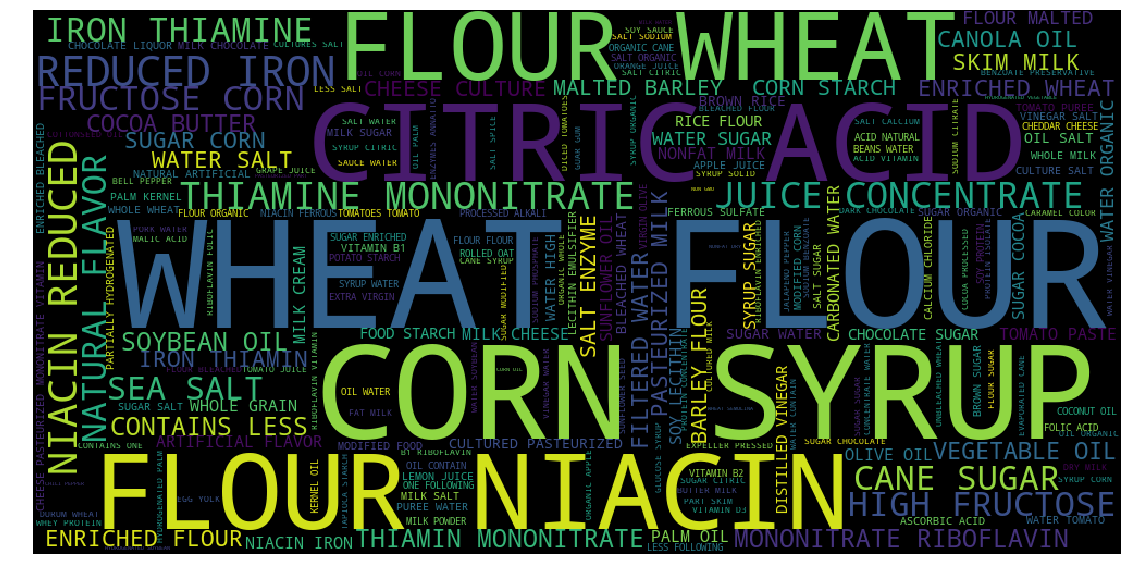

In [79]:
ten_ingredients = [' '.join(a.split(',')[:5]) for a in ingredients_list]
wc = wordcloud.WordCloud(width = 1000, height = 500).generate(' '.join(ten_ingredients))
plt.figure(figsize=(20,10))
plt.imshow(wc)
plt.axis("off")
plt.show()

In [69]:
three_ingredients[:5]

[u'ICE CREAM INGREDIENTS: MILK  CREAM  SUGAR',
 u'WATER  SUGAR  TOMATO PASTE',
 u'SUGAR  WATER  DISTILLED VINEGAR',
 u'TOMATO PUREE(WATER  TOMATO PASTE)  SUGAR',
 u'SUGAR  DISTILLED VINEGAR  WATER']

In [54]:
dtm = cvectorizer.fit_transform(three_ingredients)

In [68]:
[a for a in first_ingredient if a.startswith(u'02')]

[]

In [55]:
print len(cvectorizer.get_feature_names())
cvectorizer.get_feature_names()

2743


[u'00',
 u'000',
 u'02',
 u'10',
 u'100',
 u'100g',
 u'11',
 u'12',
 u'120',
 u'13',
 u'14',
 u'15',
 u'16',
 u'17',
 u'18',
 u'180',
 u'19',
 u'1st',
 u'20',
 u'2000',
 u'21',
 u'22',
 u'23',
 u'24',
 u'25',
 u'26',
 u'27',
 u'28',
 u'29',
 u'2nd',
 u'30',
 u'31',
 u'32',
 u'32mg',
 u'33',
 u'34',
 u'35',
 u'36',
 u'37',
 u'38',
 u'39',
 u'40',
 u'400',
 u'41',
 u'42',
 u'43',
 u'44',
 u'45',
 u'46',
 u'47',
 u'48',
 u'49',
 u'50',
 u'51',
 u'52',
 u'53',
 u'54',
 u'55',
 u'56',
 u'57',
 u'58',
 u'5856',
 u'59',
 u'60',
 u'6086',
 u'61',
 u'62',
 u'64',
 u'65',
 u'66',
 u'68',
 u'70',
 u'71',
 u'72',
 u'73',
 u'75',
 u'76',
 u'78',
 u'79',
 u'80',
 u'82',
 u'84',
 u'85',
 u'86',
 u'87',
 u'88',
 u'89',
 u'90',
 u'92',
 u'93',
 u'94',
 u'95',
 u'96',
 u'97',
 u'98',
 u'99',
 u'aa',
 u'absorbic',
 u'acacia',
 u'acai',
 u'acerola',
 u'acesulfame',
 u'acetate',
 u'acetic',
 u'aceto',
 u'acid',
 u'acidifier',
 u'acidity',
 u'acidophilus',
 u'acids',
 u'acidulant',
 u'activated',
 u'active'

In [26]:
dtm.argmax()%5076


3250

In [23]:
dtm.shape

(175228, 5076)

In [34]:
cvectorizer.vocabulary_.get?

|  |  |
|---|---|
|test|test|
|--|--|

In [ ]:
def get_categories(num): 
    '''Obtain term frequencies for ingredients up to the num-th ingredient'''
    

In [315]:
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer

In [317]:
transformer = TfidfTransformer()

In [318]:
tfidfm = transformer.fit_transform(dtm)

In [126]:
from time import time

In [336]:
wordcloud.query_integral_image?

In [325]:
lda = LatentDirichletAllocation(max_iter=5, learning_method='online', 
                               learning_offset=50, random_state=0)

lda.fit(tfidfm)

for topic_idx, topic in enumerate(lda.components_): 
    print("Topic #%d:" % topic_idx) 
    print(" ".join([cvectorizer.get_feature_names()[i] 
                    for i in topic.argsort()[:-20-1:-1]
                   ]))

Topic #0:
flour wheat niacin folic mononitrate riboflavin iron enriched oil acid thiamine reduced soybean thiamin bleached barley palm malted corn water
Topic #1:
organic rice seeds sunflower 100 honey brown cane pure coconut oil sea oats grain flour cranberries raw stevia sugar maple
Topic #2:
vitamin carbonated d3 palmitate milk natural fat water niacinamide flavor calcium phosphate hydrochloride reduced flavors pistachios oxide vitamins carbonate beets
Topic #3:
vinegar garlic salt oil pepper water tomato olive peppers spices onion distilled tomatoes virgin extra powder red sugar juice onions
Topic #4:
acid corn citric potassium artificial syrup natural yellow red 40 water flavors sodium benzoate preservative flavor color fructose sugar blue
Topic #5:
sodium salt chicken beef pork water powder contains corn dextrose nitrite natural spices onion sugar extract phosphate paprika garlic erythorbate
Topic #6:
organic juice concentrate water beans filtered apple ascorbic acid lemon cane p

In [330]:
lda_topic = []
for topic in lda.components_: 
    lda_topic.append([cvectorizer.get_feature_names()[i] 
                 for i in topic.argsort()[:-20-1:-1]])

In [326]:
from sklearn.decomposition import NMF 

# Topic modeling using non-negative matrix factorization
nmf = NMF(n_components=10, random_state=1, alpha=.1, l1_ratio=.5).fit(tfidfm)

for topic_idx, topic in enumerate(nmf.components_): 
    print("Topic #%d:" % topic_idx) 
    print(" ".join([cvectorizer.get_feature_names()[i] 
                    for i in topic.argsort()[:-20-1:-1]
                   ]))

Topic #0:
corn syrup potassium fructose high gum carbonated preservative natural water benzoate flavor acid citric color sorbate caramel flavors guar calcium
Topic #1:
organic sea cane rice coconut seeds brown sunflower flour water filtered pressed raw wheat evaporated expeller oats beans puree black
Topic #2:
flour wheat niacin folic mononitrate riboflavin iron enriched oil thiamine acid reduced soybean thiamin barley malted palm bleached yeast sulfate
Topic #3:
cheese milk pasteurized enzymes culture salt cultures cultured annatto cream skim cheddar color whey gum caking cellulose prevent natamycin parmesan
Topic #4:
chocolate cocoa milk butter sugar lecithin soy vanilla emulsifier liquor oil palm powder processed cream alkali flavor nonfat kernel coconut
Topic #5:
salt garlic oil powder vinegar onion spices tomato pepper water peppers sea dehydrated paprika canola sugar tomatoes paste sunflower distilled
Topic #6:
juice concentrate acid apple lemon citric ascorbic water filtered gra

In [332]:
nmf_topic = []
for topic in nmf.components_: 
    nmf_topic.append([cvectorizer.get_feature_names()[i] 
                    for i in topic.argsort()[:-20-1:-1]
                   ])

In [333]:
nmf_topic

[[u'corn',
  u'syrup',
  u'potassium',
  u'fructose',
  u'high',
  u'gum',
  u'carbonated',
  u'preservative',
  u'natural',
  u'water',
  u'benzoate',
  u'flavor',
  u'acid',
  u'citric',
  u'color',
  u'sorbate',
  u'caramel',
  u'flavors',
  u'guar',
  u'calcium'],
 [u'organic',
  u'sea',
  u'cane',
  u'rice',
  u'coconut',
  u'seeds',
  u'brown',
  u'sunflower',
  u'flour',
  u'water',
  u'filtered',
  u'pressed',
  u'raw',
  u'wheat',
  u'evaporated',
  u'expeller',
  u'oats',
  u'beans',
  u'puree',
  u'black'],
 [u'flour',
  u'wheat',
  u'niacin',
  u'folic',
  u'mononitrate',
  u'riboflavin',
  u'iron',
  u'enriched',
  u'oil',
  u'thiamine',
  u'acid',
  u'reduced',
  u'soybean',
  u'thiamin',
  u'barley',
  u'malted',
  u'palm',
  u'bleached',
  u'yeast',
  u'sulfate'],
 [u'cheese',
  u'milk',
  u'pasteurized',
  u'enzymes',
  u'culture',
  u'salt',
  u'cultures',
  u'cultured',
  u'annatto',
  u'cream',
  u'skim',
  u'cheddar',
  u'color',
  u'whey',
  u'gum',
  u'caking',
 

In [ ]:
#unhealthy foods: sugar added 

In [334]:
tfidfm.

<175228x4994 sparse matrix of type '<type 'numpy.float64'>'
	with 3484462 stored elements in Compressed Sparse Row format>

In [339]:
lda.components_.shape

(10, 4994)

In [340]:
nmf.components_.shape

(10, 4994)